# Module 3 Project

## Team Monjon

## Contributors : John Naujoks, Mando Iwanaga

----

**Import necessary packages**

In [3]:
# General setup
import pandas as pd
import numpy as np
import re
import itertools
from functions import ohe_list_col

# Modeling tools
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


# Preprocessing and scoring
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, average_precision_score
from sklearn.metrics import log_loss, roc_auc_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

# Visualization
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from IPython.display import Image  
from sklearn import tree
import pydotplus
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# EDA and Data Cleaning with scrape of 2015-2019 Data
***

**We obtained our dataset through a combination of using boardgamegeek API Python package<br> and scraping  the boardgamegeek website for missing and additional data.**

In [4]:
# Complete dataset is saved in data folder as bgg_complete_1419.csv

bgg = pd.read_csv('data/bgg_complete_1419.csv', index_col=0)

In [5]:
bgg.head()

,rank,id,name,age,avg_time,min_players,max_players,mechanic,category,weight,year,geek,avg,num_rev
0,NaN,246783,Wildlands: The Unquiet Dead,14,60,2,4,[],"['Expansion for Base-game', 'Miniatures']",2.0,2018,5.653,7.44,108.0
1,12558.0,205776,Gentleman's Deal,12,60,5,9,"['Partnerships', 'Voting']","['Bluffing', 'Negotiation', 'Party Game']",1.0,2016,5.514,6.21,47.0
2,13663.0,188129,Heroes and Tricks,8,25,2,6,"['Hand Management', 'Trick-taking']","['Deduction', 'Fantasy']",0.0,2017,5.504,5.67,83.0
3,13323.0,206083,Ragers: Champions of the Arena,14,20,2,2,"['Rock-Paper-Scissors', 'Simultaneous Action S...","['Card Game', 'Fantasy', 'Fighting']",1.0,2016,5.507,5.98,36.0
4,6390.0,201006,Bumúntú,8,30,2,5,['Action / Movement Programming'],"['Animals', 'Educational']",2.0,2019,5.603,7.15,95.0


In [6]:
# Drop rows with no rank, as they are expansions to games, and not individual games
to_drop = bgg[bgg['rank'].isna()]
bgg.drop(to_drop.index, axis=0, inplace=True)
len(bgg)

3142

In [7]:
# Filling in median value for rows with 0 weight given
bgg.loc[bgg["weight"] == 0] = bgg['weight'].median()

In [8]:
# Double checking that it pulled only those for the correct year
len(bgg[bgg['year'] < 2015]), len(bgg)

(156, 3142)

In [9]:
# Dropping rows with dates prior to 2015 (bad API pull)
to_drop = bgg[bgg['year'] < 2015]
bgg.drop(to_drop.index, axis=0, inplace=True)

In [10]:
len(bgg)

2986

In [11]:
bgg.describe()

,rank,id,age,avg_time,min_players,max_players,weight,year,geek,avg,num_rev
count,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000
mean,5627.139652,199141.554588,10.568989,125.158741,1.877763,5.687207,2.185205,2016.504689,5.844739,6.967579,844.825184
std,3892.970305,34978.264744,3.419438,2210.236276,0.693686,20.202906,0.777614,1.194408,0.459034,0.757621,2586.059547
min,1.000000,16271.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2015.000000,4.779000,2.440000,30.000000
25%,2452.500000,176533.500000,8.000000,30.000000,1.000000,4.000000,1.600000,2015.000000,5.565000,6.510000,92.000000
50%,5066.500000,197185.000000,12.000000,50.000000,2.000000,4.000000,2.062500,2016.000000,5.653000,6.960000,190.000000
75%,7925.500000,225122.250000,13.000000,90.000000,2.000000,5.000000,2.708300,2017.000000,5.940000,7.430000,539.500000
max,17135.000000,272409.000000,21.000000,120000.000000,8.000000,999.000000,5.000000,2019.000000,8.610000,9.600000,51149.000000


In [12]:
len(bgg[bgg['num_rev'] < 50])

255

In [13]:
# Removing rows with less than 50 reviews
to_drop = bgg[bgg['num_rev'] < 50]
bgg.drop(to_drop.index, axis=0, inplace=True)

In [14]:
bgg.head()

,rank,id,name,age,avg_time,min_players,max_players,mechanic,category,weight,year,geek,avg,num_rev
4,6390.0,201006.0,Bumúntú,8.0,30.0,2.0,5.0,['Action / Movement Programming'],"['Animals', 'Educational']",2.0000,2019.0,5.603,7.15,95.0
7,3426.0,256839.0,VektoRace,12.0,120.0,2.0,4.0,"['Action / Movement Programming', 'Simulation']","['Racing', 'Sports']",2.3333,2018.0,5.785,8.32,196.0
8,6801.0,258104.0,Tribes: Dawn of Humanity,10.0,45.0,2.0,4.0,"['Grid Movement', 'Tile Placement']","['Ancient', 'Civilization', 'Exploration', 'Pr...",2.4000,2018.0,5.590,6.80,99.0
11,5451.0,241796.0,Nut So Fast,8.0,20.0,3.0,6.0,['Pattern Recognition'],"['Action / Dexterity', 'Party Game']",1.0000,2018.0,5.636,7.03,157.0
14,9524.0,233206.0,Werebeasts,8.0,15.0,3.0,10.0,['Set Collection'],"['Deduction', 'Party Game']",1.5000,2018.0,5.543,6.30,94.0


In [15]:
# 'Category' and 'Mechanic' are strings that just appear to be lists. This removes the list formatting.
bgg['mechanic'] = bgg['mechanic'].apply(lambda x: re.sub("\[|\]|'","", x).replace(" ",""))
bgg['category'] = bgg['category'].apply(lambda x: re.sub("\[|\]|'","", x).replace(" ",""))

In [16]:
bgg = bgg.reset_index()
bgg.head()

,index,rank,id,name,age,avg_time,min_players,max_players,mechanic,category,weight,year,geek,avg,num_rev
0,4,6390.0,201006.0,Bumúntú,8.0,30.0,2.0,5.0,Action/MovementProgramming,"Animals,Educational",2.0000,2019.0,5.603,7.15,95.0
1,7,3426.0,256839.0,VektoRace,12.0,120.0,2.0,4.0,"Action/MovementProgramming,Simulation","Racing,Sports",2.3333,2018.0,5.785,8.32,196.0
2,8,6801.0,258104.0,Tribes: Dawn of Humanity,10.0,45.0,2.0,4.0,"GridMovement,TilePlacement","Ancient,Civilization,Exploration,Prehistoric,T...",2.4000,2018.0,5.590,6.80,99.0
3,11,5451.0,241796.0,Nut So Fast,8.0,20.0,3.0,6.0,PatternRecognition,"Action/Dexterity,PartyGame",1.0000,2018.0,5.636,7.03,157.0
4,14,9524.0,233206.0,Werebeasts,8.0,15.0,3.0,10.0,SetCollection,"Deduction,PartyGame",1.5000,2018.0,5.543,6.30,94.0


In [17]:
# Calling custom function to add One Hot Encoder columns for Mechanic types
bgg_complete = ohe_list_col(bgg, 'mechanic', 'mech_')

In our testing and review, we fouund that the category columns did not significantly contribute to any of our classification models, so for the purposes of our final model, we dropped it. 

In [18]:
bgg_complete.drop('category', axis=1, inplace=True)
bgg_complete.head()

,index,rank,id,name,age,avg_time,min_players,max_players,weight,year,...,mech__Storytelling,mech__TakeThat,mech__TilePlacement,mech__TimeTrack,mech__Trading,mech__Trick-taking,mech__VariablePhaseOrder,mech__VariablePlayerPowers,mech__Voting,mech__WorkerPlacement
0,4,6390.0,201006.0,Bumúntú,8.0,30.0,2.0,5.0,2.0000,2019.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,3426.0,256839.0,VektoRace,12.0,120.0,2.0,4.0,2.3333,2018.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8,6801.0,258104.0,Tribes: Dawn of Humanity,10.0,45.0,2.0,4.0,2.4000,2018.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,5451.0,241796.0,Nut So Fast,8.0,20.0,3.0,6.0,1.0000,2018.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14,9524.0,233206.0,Werebeasts,8.0,15.0,3.0,10.0,1.5000,2018.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
bgg_complete.shape

(2731, 67)

**Our dataset is clean and ready for the modeling process**

---

### Prep for Modeling

In [20]:
bgg_complete['geek'].describe()

count    2731.000000
mean        5.873798
std         0.469515
min         4.779000
25%         5.582000
50%         5.676000
75%         5.989000
max         8.610000
Name: geek, dtype: float64

Here we created a feature called 'top_score' using the geek score. The top 25% will be 1 and the rest will be 0. This feature will be our target for testing.

In [21]:
bgg_complete['top_score'] = bgg_complete['geek'].apply(lambda x: 1 if x > 5.989000 else 0)

In [22]:
# Define which predictors to drop

drop = ['index','rank', 'id', 'name', 'year', 'geek',
        'age', 'avg', 'num_rev', 'top_score']

to_drop = drop 

In [23]:
# Define our X and y 

X = bgg_complete.drop(to_drop, axis=1)
y = bgg_complete['top_score']

In [24]:
# Train-test split and setting a random state for reproducibility

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

*** 

## Modeling

**We will try several classification models for comparisons**

---

## Decision Tree

In [25]:
# Set random seed for reproducibility
np.random.seed(123)

clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=3, min_samples_leaf=4)

clf.fit(X_train, y_train)

y_pred_t = clf.predict_proba(X_test)

In [26]:
# Print feature importance percentages to explore how it performed.

vals = clf.feature_importances_.tolist()
best = []
for i, val in enumerate(vals):
    if round(val * 100, 2) > 1:
        print(X.columns[i] + ": " + str(round(val * 100, 2)) + "%")
        best.append(val)

avg_time: 2.12%
max_players: 3.12%
weight: 73.51%
mech__Campaign/BattleCardDriven: 1.02%
mech__CardDrafting: 6.37%
mech__CommoditySpeculation: 1.17%
mech__Deck/PoolBuilding: 1.75%
mech__Hex-and-Counter: 7.4%
mech__Simulation: 1.58%


**Evaluate Decision Tree**

Log loss: 0.8149754953134434

ROC AUC Score: 0.7160292463442071


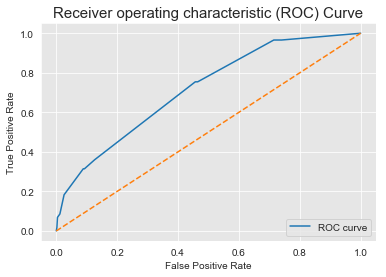

In [27]:
# Seaborn's beautiful styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print(f"Log loss: {log_loss(y_test, y_pred_t)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_t[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_t[:,1])
# Plot
plt.plot(fpr, tpr, label='ROC curve')

# This is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
plt.show;

**Visualization of Decision Tree**

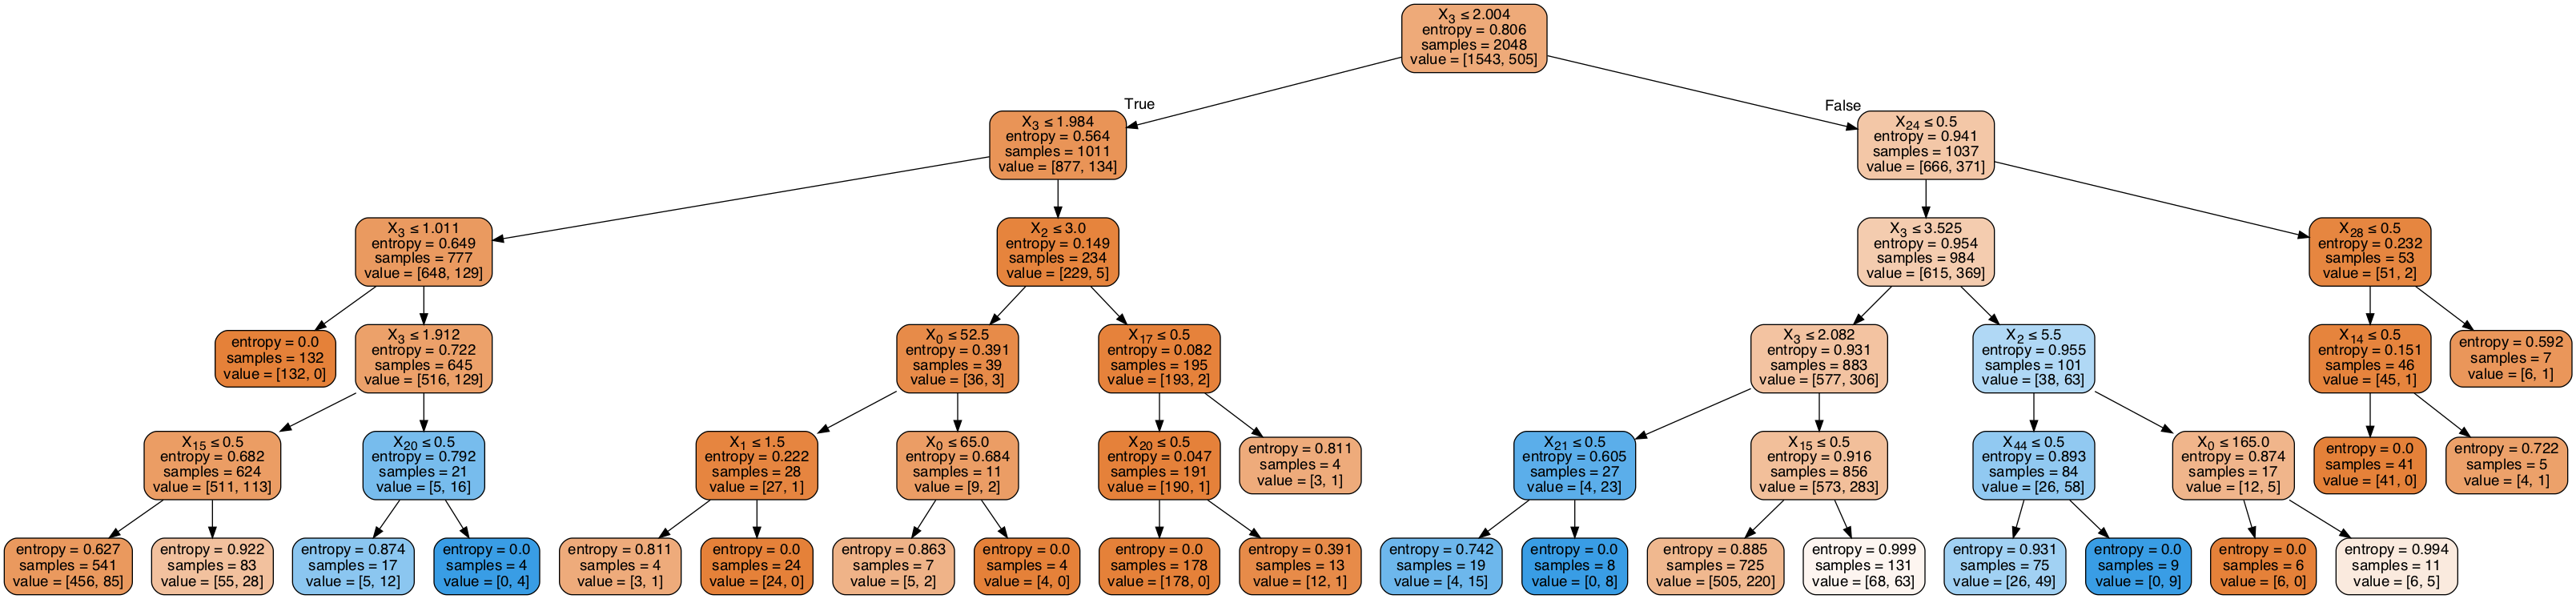

In [28]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

---

## Random Forest Classifier

In [29]:
np.random.seed(123)

forest = RandomForestClassifier(n_estimators=28, max_depth=None, min_samples_leaf=2, min_samples_split=4)

forest.fit(X_train, y_train)

y_pred_forest = forest.predict_proba(X_test)
y_pred_f = forest.predict(X_test)

In [30]:
# Print feature importance percentages

vals = forest.feature_importances_.tolist()
best = []
for i, val in enumerate(vals):
    if round(val * 100, 2) > 1:
        print(X.columns[i] + ": " + str(round(val * 100, 2)) + "%")
        best.append(val)

avg_time: 11.44%
min_players: 5.43%
max_players: 6.25%
weight: 25.17%
mech__ActionPointAllowanceSystem: 1.67%
mech__AreaControl/AreaInfluence: 2.09%
mech__AreaMovement: 1.17%
mech__CardDrafting: 5.88%
mech__CooperativePlay: 2.26%
mech__Deck/PoolBuilding: 2.33%
mech__DiceRolling: 2.39%
mech__GridMovement: 1.06%
mech__HandManagement: 2.69%
mech__Hex-and-Counter: 1.13%
mech__ModularBoard: 1.5%
mech__Partnerships: 1.44%
mech__PlayerElimination: 1.01%
mech__PointtoPointMovement: 1.02%
mech__Route/NetworkBuilding: 1.13%
mech__SetCollection: 2.36%
mech__SimultaneousActionSelection: 1.1%
mech__TakeThat: 1.07%
mech__TilePlacement: 1.71%
mech__VariablePlayerPowers: 2.43%
mech__WorkerPlacement: 2.06%


**Evaluate Random Forest**

Log loss: 0.4883961455929551

ROC AUC Score: 0.745984251968504


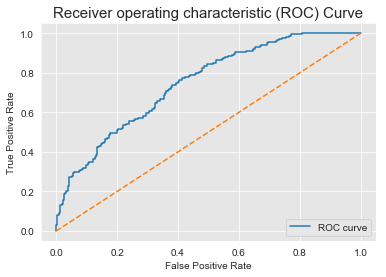

In [31]:
# Seaborn's beautiful styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print(f"Log loss: {log_loss(y_test, y_pred_forest)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_forest[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_forest[:,1])

# Plot of ROC Curve
plt.plot(fpr, tpr, label='ROC curve')

# This is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
plt.show;

---

## XG Boost Classifier

In [ ]:
np.random.seed(123)

x_boost = XGBClassifier(learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=125)

x_boost.fit(X_train, y_train)

In [42]:
x_pred = x_boost.predict_proba(X_test)

In [43]:
# Print feature importance percentages

vals = x_boost.feature_importances_.tolist()
best = []
for i, val in enumerate(vals):
    if round(val * 100, 2) > 1:
        print(X.columns[i] + ": " + str(round(val * 100, 2)) + "%")
        best.append(val)

avg_time: 5.24%
min_players: 7.46%
max_players: 8.89%
weight: 37.78%
mech__Action/MovementProgramming: 2.86%
mech__AreaControl/AreaInfluence: 1.9%
mech__CardDrafting: 3.17%
mech__CooperativePlay: 1.9%
mech__Deck/PoolBuilding: 1.27%
mech__HandManagement: 1.9%
mech__Hex-and-Counter: 3.49%
mech__HiddenTraitor: 2.22%
mech__Partnerships: 2.22%
mech__PatternRecognition: 1.75%
mech__Route/NetworkBuilding: 1.27%
mech__SetCollection: 2.06%
mech__Simulation: 1.27%
mech__Storytelling: 1.11%
mech__TakeThat: 1.11%
mech__VariablePlayerPowers: 1.59%


**Evaluate XG Boost**

Log loss: 0.487469909439957

ROC AUC Score: 0.7518503937007873


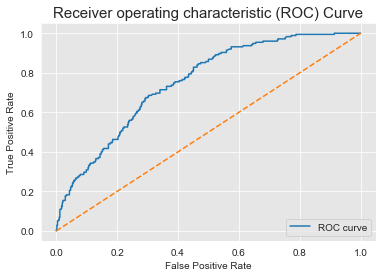

In [44]:
# Seaborn's beautiful styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print(f"Log loss: {log_loss(y_test, x_pred)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, x_pred[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, x_pred[:,1])
#Plot
plt.plot(fpr, tpr, label='ROC curve')
# this is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
plt.show;

## Gradient Boosting Classifier

In [26]:
np.random.seed(123)

boost = GradientBoostingClassifier(learning_rate=.03, max_depth=4, n_estimators=150)

boost.fit(X_train, y_train)

boost_pred = boost.predict_proba(X_test)
boost_conf_pred = boost.predict(X_test)

In [27]:
#Print feature importance percentages

vals = boost.feature_importances_.tolist()
best = []
for i, val in enumerate(vals):
    if round(val * 100, 2) > 1:
        print(X.columns[i] + ": " + str(round(val * 100, 2)) + "%")
        best.append(val)

avg_time: 5.05%
min_players: 6.44%
max_players: 2.85%
weight: 49.71%
mech__Action/MovementProgramming: 1.03%
mech__AreaControl/AreaInfluence: 1.44%
mech__CardDrafting: 5.19%
mech__CooperativePlay: 2.21%
mech__HandManagement: 1.19%
mech__Hex-and-Counter: 2.7%
mech__HiddenTraitor: 1.45%
mech__Partnerships: 1.05%
mech__Route/NetworkBuilding: 1.55%
mech__SetCollection: 1.66%
mech__Storytelling: 1.61%
mech__VariablePlayerPowers: 2.27%
mech__WorkerPlacement: 2.67%


**Evaluate Gradient Boosting**

Log loss: 0.4915397468041839

ROC AUC Score: 0.7489370078740157


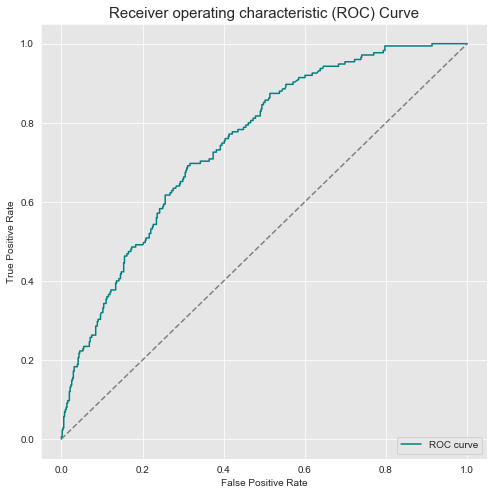

In [29]:
#Seaborn's beautiful styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(8,8))

print(f"Log loss: {log_loss(y_test, boost_pred)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, boost_pred[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, boost_pred[:,1])

#Plot
plt.plot(fpr, tpr, label='ROC curve', color='teal') 

# This is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--', color='grey');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
plt.show;
plt.savefig('../rock.png')

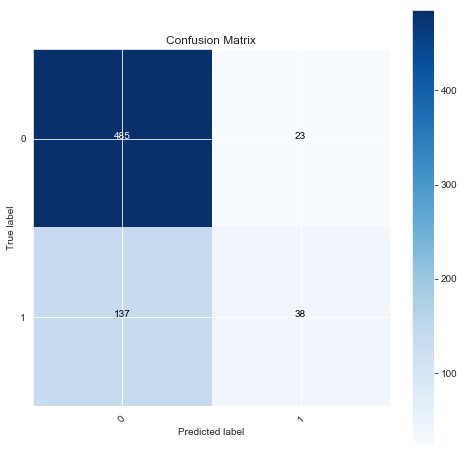

In [59]:
cnf_matrix = confusion_matrix(y_test, boost_conf_pred)
# Plot functions: 
plt.figure(figsize=(8,8))
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) 

# Add title and Axis Labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add appropriate Axis Scales
class_names = set(y) #Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add Labels to Each Cell
thresh = cnf_matrix.max() / 2.

# Here we iterate through the confusion matrix and append labels to our visualization.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

# Add a Side Bar Legend Showing Colors
plt.colorbar();

In [36]:
# Checking the Cross Validation Score
print(cross_val_score(boost, X, y, cv=5))

[0.78610603 0.79304029 0.77472527 0.71428571 0.75824176]


---

### Final thoughts
Based on our results, it appears we achieve very similar results with all our models.  The XG Boost model appears to have done the best, though due to it's computational cost, the Gradient Descent Classifier would probably be our best option. The further checking through Cross Validation gives us confidence that this would be a good model.

---

##### Other testing:

## Logistic Regression

In [45]:
logreg = LogisticRegression(solver='liblinear', penalty="l1") #Starter code
model_log = logreg.fit(X_train, y_train)
print(model_log) #Preview model params

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)


In [ ]:
logreg_pred = logreg.predict(X_test)

In [45]:
y_score = logreg.fit(X_train, y_train).decision_function(X_test)

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

**Evaluate Logistic Regression**

In [47]:
##Seaborn's beautiful styling
#sns.set_style("darkgrid", {"axes.facecolor": ".9"})

#print(f"Log loss: {log_loss(y_test, x_pred)}")
#print(f"\nROC AUC Score: {roc_auc_score(y_test, x_pred[:,1])}")
#fpr, tpr, thresholds = roc_curve(y_test, x_pred[:,1])
##Plot
#plt.plot(fpr, tpr, label='ROC curve')
## this is just a diagonal
#plt.plot([0, 1], [0, 1], linestyle='--');
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.legend(loc="lower right")
#plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
#plt.show;

**SMOTE for Logistic Regression**

In [48]:
#print(y.value_counts()) #Previous original class distribution
#X_resampled, y_resampled = SMOTE().fit_sample(X, y) 
#print(pd.Series(y_resampled).value_counts())

In [49]:
#X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled)


In [50]:
#logreg_pred = logreg.predict(X_test)
#y_log_pred_smote = logreg.predict_proba(X_test)

In [51]:
#y_score = logreg.fit(X_train, y_train).decision_function(X_test)

#fpr, tpr, thresholds = roc_curve(y_test, y_score)

**Evaluate Logistic Regression after SMOTE**

In [52]:
##Seaborn's beautiful styling
#sns.set_style("darkgrid", {"axes.facecolor": ".9"})

#print(f"Log loss: {log_loss(y_test, y_log_pred_smote)}")
#print(f"\nROC AUC Score: {roc_auc_score(y_test, logreg_pred[:,1])}")
#fpr, tpr, thresholds = roc_curve(y_test, logreg_pred[:,1])
##Plot
#plt.plot(fpr, tpr, label='ROC curve')
## this is just a diagonal
#plt.plot([0, 1], [0, 1], linestyle='--');
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.legend(loc="lower right")
#plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
#plt.show;

---

## K-Nearest Neighbors for assessing similarity to other games

In [34]:
kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [35]:
guess = np.array(X.iloc[25]).reshape(1,-1)

In [36]:
kn.kneighbors(guess)[1][0]

array([  25, 1937,  977])

In [37]:
bgg_complete.loc[25]['name'], bgg_complete.loc[1937]['name']

('Ladder 29', 'Custom Heroes')

In [38]:
pca = PCA(n_components=1) # Number of principal components required
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [39]:
print(pca.explained_variance_ratio_.tolist())

[0.9999176552663673]


---

## GridSearchCV

**Run GridSearch on models to find the best parameters**

**Decision Tree**

In [140]:
param_grid_clf = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 4, 5],
    "min_samples_split": [3, 4, 5],
    "min_samples_leaf": [2, 3, 4, 5]
}

In [141]:
gs_clf = GridSearchCV(clf, param_grid_clf, cv=3)

In [142]:
gs_clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 4, 5], 'min_samples_split': [3, 4, 5], 'min_samples_leaf': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [143]:
gs_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 3}

**Random Forest**

In [147]:
param_grid_forest = {
    "n_estimators": [25, 28, 30, 32],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 3],
    "min_samples_split": [4, 5, 6],
    "min_samples_leaf": [1, 2]
}

In [148]:
gs_forest = GridSearchCV(forest, param_grid_forest, cv=3)

In [149]:
gs_forest.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [25, 28, 30, 32], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 3], 'min_samples_split': [4, 5, 6], 'min_samples_leaf': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [150]:
gs_forest.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 28}

**Gradient Boosting**

In [165]:
param_grid_gb = {
    "learning_rate": [0.2, 0.3, 0.4],
    "n_estimators": [125, 150, 175],
    "max_depth": [3, 4, 5]
}

In [166]:
gs_boost = GridSearchCV(boost, param_grid_gb, cv=3)

In [167]:
gs_boost.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samp...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.2, 0.3, 0.4], 'n_estimators': [125, 150, 175], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [168]:
gs_boost.best_params_

{'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 150}

**XGBoost**

In [190]:
param_grid_xgb = {
    "learning_rate": [0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'n_estimators': [100, 125, 150],
}

In [191]:
gs_xgb = GridSearchCV(x_boost, param_grid_xgb, cv=3)

In [192]:
gs_xgb.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [3, 4, 5], 'min_child_weight': [1, 2, 3], 'n_estimators': [100, 125, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [193]:
gs_xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 2,
 'n_estimators': 125}

**Logistic Regression**

In [ ]:
#logreg = LogisticRegression(solver='lbfgs')

In [ ]:
#param_grid_logreg = {
 #   "max_iter": [170, 175, 180],
  #  "penalty": ["l1", "l2"]
#}

In [ ]:
#gs_tree_logreg = GridSearchCV(logreg, param_grid_logreg, cv=3)

In [ ]:
#gs_tree_logreg.fit(X_train, y_train)

In [ ]:
#gs_tree_logreg.best_params_